# Assignment2

## Read the raw data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv("NY property data.csv")

In [3]:
data.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Filling In Missing ZIP

In [4]:
# missing zip 
missing_zips=np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

29890

In [5]:
# if before and after are the same, replace by that zip code
for i in range(len(missing_zips)):
    if data.loc[missing_zips[i]+1,'ZIP']==data.loc[missing_zips[i]-1,'ZIP']:
        data.loc[missing_zips[i],'ZIP']=data.loc[missing_zips[i]-1,'ZIP'] 

In [6]:
missing_zips=np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

16437

In [7]:
# for the rest,
# replace all the missing zips with the zip from the record above it
for i in range(len(missing_zips)):
    data.loc[missing_zips[i],'ZIP']=data.loc[missing_zips[i]-1,'ZIP'] 

In [8]:
# check whether there are left
missing_zips=np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

## Filling In Missing STORIES

In [9]:
temp=data[data['STORIES'].isnull()]
len(temp)

56264

In [10]:
temp['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [11]:
# groupby TAXCLASS, since that’s a pretty good description of the nature of the buildings
mean_stories=data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64


In [12]:
len(data[data['STORIES']==0])

0

In [13]:
# fill in with the average by that record’s TAXCLASS
data['STORIES']=data['STORIES'].fillna(value=0)
for index in mean_stories.index:
    data.loc[(data['STORIES']==0)&(data['TAXCLASS']==index),'STORIES']=mean_stories[index]

## Calculate means for FULLVAL, AVLAND, AVTOT by TAXCLASS, avoiding 0

In [14]:
data['FULLVAL'].replace('NaN',0)
temp=data[data['FULLVAL']!=0]
mean_fullval=temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64


In [15]:
data['AVLAND'].replace('NaN',0)
temp_avland=data[data['AVLAND']!=0]
mean_avland=temp.groupby('TAXCLASS')['AVLAND'].mean()

In [16]:
data['AVTOT'].replace('NaN',0)
temp_avtot=data[data['AVTOT']!=0]
mean_avtot=temp.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for FULLVAL, AVLAND, AVTOT  from averages by taxclass

In [17]:
%%time
for index in mean_fullval.index:
    data.loc[(data['FULLVAL']==0)&(data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    data.loc[(data['AVLAND']==0)&(data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    data.loc[(data['AVTOT']==0)&(data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 2.59 s, sys: 145 ms, total: 2.73 s
Wall time: 3.3 s


## Filling In Missing Lot and Building Sizes

In [18]:
# as these 4 values do not have NAs, we just need to replace 0s. 
# calculate groupwise average. 1st replace 0 by NAs so they are not counted in calculating mean.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan

In [19]:
# add new treatment for 1 (pretend it's missing in assignment 4)
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [20]:
# calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=data.groupby(data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=data.groupby(data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=data.groupby(data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=data.groupby(data['TAXCLASS'])['BLDDEPTH'].mean()

In [21]:
# impute values
for index in mean_LTFRONT.index:
    data.loc[(data['LTFRONT'].isnull())&(data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    data.loc[(data['LTDEPTH'].isnull())&(data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    data.loc[(data['BLDFRONT'].isnull())&(data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    data.loc[(data['BLDDEPTH'].isnull())&(data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

## Making New Variables

In [22]:
# convert zip to an integer but float
# create a new zip3 variable
data['ZIP']=data['ZIP'].astype(str)
data['zip3']=data['ZIP'].str[:3]

In [28]:
# data.rename(columns={'ZIP3':'zip3'}, inplace=True)

In [23]:
data['ltsize']=data['LTFRONT']*data['LTDEPTH']
data['bldsize']=data['BLDFRONT']*data['BLDDEPTH']
data['bldvol']=data['bldsize']*data['STORIES']

In [24]:
# make typical measures of how normal a property is
data['r1']=data['FULLVAL']/data['ltsize']
data['r2']=data['FULLVAL']/data['bldsize']
data['r3']=data['FULLVAL']/data['bldvol']
data['r4']=data['AVLAND']/data['ltsize']
data['r5']=data['AVLAND']/data['bldsize']
data['r6']=data['AVLAND']/data['bldvol']
data['r7']=data['AVTOT']/data['ltsize']
data['r8']=data['AVTOT']/data['bldsize']
data['r9']=data['AVTOT']/data['bldvol']

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 45 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   BBLE      1070994 non-null  object 
 2   B         1070994 non-null  int64  
 3   BLOCK     1070994 non-null  int64  
 4   LOT       1070994 non-null  int64  
 5   EASEMENT  4636 non-null     object 
 6   OWNER     1039249 non-null  object 
 7   BLDGCL    1070994 non-null  object 
 8   TAXCLASS  1070994 non-null  object 
 9   LTFRONT   1070994 non-null  float64
 10  LTDEPTH   1070994 non-null  float64
 11  EXT       354305 non-null   object 
 12  STORIES   1070994 non-null  float64
 13  FULLVAL   1070994 non-null  float64
 14  AVLAND    1070994 non-null  float64
 15  AVTOT     1070994 non-null  float64
 16  EXLAND    1070994 non-null  float64
 17  EXTOT     1070994 non-null  float64
 18  EXCD1     638488 non-null   float64
 19  STADDR    1070318 non

In [26]:
ninevars=['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean=data.groupby('ZIP')[ninevars].mean()
zip3_mean=data.groupby('zip3')[ninevars].mean()
taxclass_mean=data.groupby('TAXCLASS')[ninevars].mean()
borough_mean=data.groupby('B')[ninevars].mean()
data=data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data=data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data=data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
data=data.join(borough_mean, on='B', rsuffix='_boro')
rsuffix=['_zip5', '_zip3', '_taxclass', '_boro']

for var in ninevars:
    for r in rsuffix:
        data[str(var)+r]=data[var]/data[str(var)+r]

## Output the cleaned dataset

In [27]:
data.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,25.310494,150.743329,62.545284,46.002691,116.736212,40.294396,21.272775,261.531359,107.839517,84.807469
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,216.090453,1.881096,98.033545,392.751808,8.770206,380.238492,1093.428533,3.263598,169.027775,724.050838


In [28]:
rec=[917942,565392,85886,67129,684704,690833,915469,44248,565398,1059883]

In [30]:
# drop any columns that aren't needed
data2=data.drop(data.iloc[:, 1:36], axis = 1) 
data2.iloc[:,1:] = (data2.iloc[:,1:] - data2.iloc[:,1:].mean()) / data2.iloc[:,1:].std()
data2.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,-0.255761,1.391255,0.298531,-0.016532,0.733160,0.191155,-0.032729,1.279582,0.410407,...,0.239674,-0.291407,1.378940,0.423640,-0.035493,0.353823,0.146368,-0.069324,0.464675,0.328655
1,2,80.032072,14.476590,4.049227,22.085202,2.552784,0.699158,89.652154,11.941798,3.980206,...,3.246255,49.308730,14.368584,4.673052,5.392397,1.275732,0.561827,22.564714,4.551318,3.292858
2,3,0.075242,-0.120576,-0.108520,0.483982,0.070334,0.028791,0.337016,0.047709,0.022988,...,-0.086621,-0.086920,-0.121835,-0.037535,0.087427,0.018003,0.013581,0.023990,-0.007480,0.006960
3,4,-0.182636,0.126486,0.113608,0.133577,0.303320,0.231186,0.048955,0.249021,0.234403,...,0.091438,-0.246232,0.123420,0.214128,0.001372,0.136044,0.179106,-0.048709,0.069679,0.182510
4,5,0.685581,22.822842,35.829707,1.602135,24.336380,37.030788,1.018790,18.742506,34.227910,...,28.721692,0.290135,22.653802,40.679265,0.362030,12.312361,30.274899,0.196051,7.157913,28.409205


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5]),
 [Text(0.5, 1, 'r1'),
  Text(1.5, 1, 'r2'),
  Text(2.5, 1, 'r3'),
  Text(3.5, 1, 'r4'),
  Text(4.5, 1, 'r5'),
  Text(5.5, 1, 'r6'),
  Text(6.5, 1, 'r7'),
  Text(7.5, 1, 'r8'),
  Text(8.5, 1, 'r9'),
  Text(9.5, 1, 'r1_zip5'),
  Text(10.5, 1, 'r2_zip5'),
  Text(11.5, 1, 'r3_zip5'),
  Text(12.5, 1, 'r4_zip5'),
  Text(13.5, 1, 'r5_zip5'),
  Text(14.5, 1, 'r6_zip5'),
  Text(15.5, 1, 'r7_zip5'),
  Text(16.5, 1, 'r8_zip5'),
  Text(17.5, 1, 'r9_zip5'),
  Text(18.5, 1, 'r1_zip3'),
  Text(19.5, 1, 'r2_zip3'),
  Text(20.5, 1, 'r3_zip3'),
  Text(21.5, 1, 'r4_zip3'),
  Text(22.5, 1, 'r5_zip3'),
  Text(23.5, 1, 'r6_zip3'),
  Text(24.5, 1, 'r7_zip3'),
  Text(25.5, 1, 'r8_zip3'),
  Text(26.5, 1,

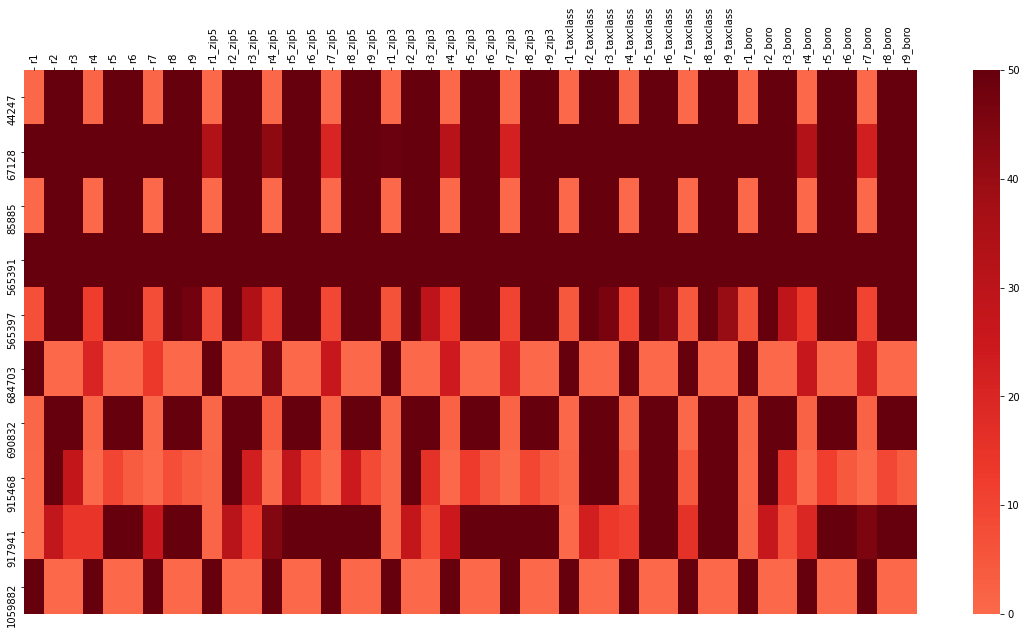

In [36]:
data_heatmap = data2[data2.RECORD.isin(rec)].iloc[:,1:].abs()
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 46 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   RECORD       1070994 non-null  int64  
 1   r1           1070994 non-null  float64
 2   r2           1070994 non-null  float64
 3   r3           1070994 non-null  float64
 4   r4           1070994 non-null  float64
 5   r5           1070994 non-null  float64
 6   r6           1070994 non-null  float64
 7   r7           1070994 non-null  float64
 8   r8           1070994 non-null  float64
 9   r9           1070994 non-null  float64
 10  r1_zip5      1070994 non-null  float64
 11  r2_zip5      1070994 non-null  float64
 12  r3_zip5      1070994 non-null  float64
 13  r4_zip5      1070994 non-null  float64
 14  r5_zip5      1070994 non-null  float64
 15  r6_zip5      1070994 non-null  float64
 16  r7_zip5      1070994 non-null  float64
 17  r8_zip5      1070994 non-null  float64
 18  r9

In [43]:
# stats = data.describe().transpose()
# stats.to_csv('stats_on_vars.csv')

In [28]:
data.drop(data.iloc[:, 1:36], inplace = True, axis = 1)
data.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3784.190253,694.733351,8.079350,747.200744,137.177373,18.413002,1702.885614,312.630008,...,2.624110,0.114401,6.878229,4.993136,0.234725,11.759225,6.071127,0.197696,11.818277,9.069199
1,2,53655.384245,34269.909866,6291.557172,3961.860416,2530.456193,464.562348,24144.922910,15421.459440,2831.200728,...,23.764139,150.013517,62.289753,45.218210,115.101896,39.823572,20.560366,259.238195,107.027200,82.131345
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,...,0.329614,0.731948,0.475847,0.627187,2.834128,1.535244,1.439136,1.264879,0.817607,1.139181
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,...,1.580700,0.250829,1.521315,3.007743,1.014310,5.126053,7.207730,0.433458,2.613947,5.463065
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,...,202.743398,1.870646,97.563288,385.778484,8.641219,375.527135,1056.055560,3.232662,167.634723,700.702336


# Assignment 3

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
# this dataset has 45 columns
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.255761,1.391255,0.298531,-0.016532,0.733160,0.191155,-0.032729,1.279582,0.410407,-0.316187,...,0.239674,-0.291407,1.378940,0.423640,-0.035493,0.353823,0.146368,-0.069324,0.464675,0.328655
1,80.032072,14.476590,4.049227,22.085202,2.552784,0.699158,89.652154,11.941798,3.980206,45.870785,...,3.246255,49.308730,14.368584,4.673052,5.392397,1.275732,0.561827,22.564714,4.551318,3.292858
2,0.075242,-0.120576,-0.108520,0.483982,0.070334,0.028791,0.337016,0.047709,0.022988,-0.125772,...,-0.086621,-0.086920,-0.121835,-0.037535,0.087427,0.018003,0.013581,0.023990,-0.007480,0.006960
3,-0.182636,0.126486,0.113608,0.133577,0.303320,0.231186,0.048955,0.249021,0.234403,-0.274121,...,0.091438,-0.246232,0.123420,0.214128,0.001372,0.136044,0.179106,-0.048709,0.069679,0.182510
4,0.685581,22.822842,35.829707,1.602135,24.336380,37.030788,1.018790,18.742506,34.227910,0.225337,...,28.721692,0.290135,22.653802,40.679265,0.362030,12.312361,30.274899,0.196051,7.157913,28.409205


In [163]:
len(data)

1070994

In [141]:
data_orig = data.copy()
data.drop(columns='RECORD', inplace=True)

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 45 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   r1           1070994 non-null  float64
 1   r2           1070994 non-null  float64
 2   r3           1070994 non-null  float64
 3   r4           1070994 non-null  float64
 4   r5           1070994 non-null  float64
 5   r6           1070994 non-null  float64
 6   r7           1070994 non-null  float64
 7   r8           1070994 non-null  float64
 8   r9           1070994 non-null  float64
 9   r1_zip5      1070994 non-null  float64
 10  r2_zip5      1070994 non-null  float64
 11  r3_zip5      1070994 non-null  float64
 12  r4_zip5      1070994 non-null  float64
 13  r5_zip5      1070994 non-null  float64
 14  r6_zip5      1070994 non-null  float64
 15  r7_zip5      1070994 non-null  float64
 16  r8_zip5      1070994 non-null  float64
 17  r9_zip5      1070994 non-null  float64
 18  r1

In [143]:
# z scaling for the whole dataset
data = (data - data.mean()) / data.std()

In [164]:
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.255761,1.391255,0.298531,-0.016532,0.733160,0.191155,-0.032729,1.279582,0.410407,-0.316187,...,0.239674,-0.291407,1.378940,0.423640,-0.035493,0.353823,0.146368,-0.069324,0.464675,0.328655
1,80.032072,14.476590,4.049227,22.085202,2.552784,0.699158,89.652154,11.941798,3.980206,45.870785,...,3.246255,49.308730,14.368584,4.673052,5.392397,1.275732,0.561827,22.564714,4.551318,3.292858
2,0.075242,-0.120576,-0.108520,0.483982,0.070334,0.028791,0.337016,0.047709,0.022988,-0.125772,...,-0.086621,-0.086920,-0.121835,-0.037535,0.087427,0.018003,0.013581,0.023990,-0.007480,0.006960
3,-0.182636,0.126486,0.113608,0.133577,0.303320,0.231186,0.048955,0.249021,0.234403,-0.274121,...,0.091438,-0.246232,0.123420,0.214128,0.001372,0.136044,0.179106,-0.048709,0.069679,0.182510
4,0.685581,22.822842,35.829707,1.602135,24.336380,37.030788,1.018790,18.742506,34.227910,0.225337,...,28.721692,0.290135,22.653802,40.679265,0.362030,12.312361,30.274899,0.196051,7.157913,28.409205


## PCA

(0.0, 1.0)

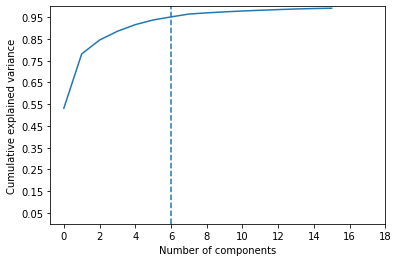

In [165]:
# compute most of the PC components and look at the scree plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [166]:
# decide to just keep the top 6 PCs based on the plots
pca = PCA(n_components = 7)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1070994, 7)

In [167]:
# z scaling the PCs
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-1.718846e-16,-5.445269e-16,-1.686205e-16,-1.135972e-15,-2.066915e-15,7.482568e-16,-1.172276e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.473123e-01,-3.121770e+02,-4.693497e+02,-1.839580e+02,-3.911585e+02,-2.618062e+02,-2.129455e+02
25%,-6.862403e-02,-9.947862e-02,-6.131602e-02,-1.448078e-01,-1.114987e-01,-7.018084e-02,-1.120018e-01
50%,-1.944495e-02,-4.105365e-02,1.099320e-02,-2.396821e-02,-5.630885e-02,7.532041e-04,4.429785e-03
75%,1.192503e-02,2.033200e-02,1.500593e-01,5.505629e-02,3.222931e-02,1.235221e-01,8.383810e-02
max,5.229280e+02,6.036698e+02,6.141779e+02,3.898520e+02,4.478940e+02,4.230684e+02,3.327273e+02


## model1: z score outliers

In [168]:
p=3
oop=1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**oop

In [169]:
score1

0           1.611644
1          63.172772
2           0.190267
3           0.277603
4          34.572682
             ...    
1070989     0.223371
1070990     0.310079
1070991     0.294222
1070992     0.284770
1070993     0.156899
Length: 1070994, dtype: float64

## model2: autoencoder error

In [172]:
# placeholder for input
data_in = Input(shape=(7,))
# dimension of the encoded data
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(7,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

In [173]:
# compile the final model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(data_pca,data_pca, epochs=5, shuffle=True, validation_data=(data_pca,data_pca))
pca_out = autoencoder.predict(data_pca)

Epoch 1/5
33469/33469 [==============================] - 37s 1ms/step - loss: 0.9953 - val_loss: 0.9267
Epoch 2/5
33469/33469 [==============================] - 36s 1ms/step - loss: 1.2097 - val_loss: 0.9255
Epoch 3/5
33469/33469 [==============================] - 38s 1ms/step - loss: 0.7618 - val_loss: 0.9255
Epoch 4/5
33469/33469 [==============================] - 59s 2ms/step - loss: 0.8897 - val_loss: 0.9250
Epoch 5/5
33469/33469 [==============================] - 37s 1ms/step - loss: 1.0416 - val_loss: 0.9253


In [174]:
# find the error 
error = pca_out-data_pca
p=4
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

## Create the two scores

In [175]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
scores.head()

,score1,score2,score1 rank,score2 rank,final
0,1.611644,1.049943,1048284.0,1055652.0,1051968.0
1,63.172772,54.450287,1070893.0,1070889.0,1070891.0
2,0.190267,0.137430,485581.0,908248.0,696914.5
3,0.277603,0.194374,657945.0,978910.0,818427.5
4,34.572682,30.591961,1070763.0,1070763.0,1070763.0


In [176]:
scores.sort_values(['final'], ascending = False)

,score1,score2,score1 rank,score2 rank,final
917941,770.576684,695.308078,1070994.0,1070994.0,1070994.0
565391,718.773967,659.356934,1070993.0,1070993.0,1070993.0
85885,665.220499,606.209909,1070992.0,1070992.0,1070992.0
684703,474.379722,448.165283,1070991.0,1070991.0,1070991.0
67128,472.304012,427.793914,1070990.0,1070990.0,1070990.0
...,...,...,...,...,...
1036090,0.023978,0.007670,365.5,235.5,300.5
1036089,0.023978,0.007670,365.5,235.5,300.5
1036084,0.023978,0.007670,365.5,235.5,300.5
1036085,0.023978,0.007670,365.5,235.5,300.5


In [177]:
# this is the natural index 
top_records = scores.sort_values(['final'], ascending = False).head(100).index
top_records

Int64Index([ 917941,  565391,   85885,  684703,   67128,  915468,  690832,
              44247, 1059882,  116646,   39769,     418,  565397,  556608,
             501142,   33750,  738017,  106680, 1065869,  151043,  252833,
             957063,  918203,   48220,  139725,  964933,  927226,  918857,
             104410,  932860,   19241,  771149,  915469,  752487,  684562,
             985596,   97083,  610681,  330290,  691878,  964947,  245572,
              60468,  934792,  109066,  556910,  720599,   56135,  649674,
             665157,  973911,  773561,  153069,  764311,  464854,  216947,
             923882,  918304,  248664,   47983,  621688,  340899,   85883,
             177645,  991516,  209713,  209711,  131602,  918204,  817348,
              86945,  994818,  994812,  994814,  994816,  243058,  451671,
             638992,  917059,  174538,  994820,   26242,  992070,   12075,
              56133,  934749,  773734,  334956,  918919,  398277,  991782,
             330291,   79

(0.1, 2142747.525661616)

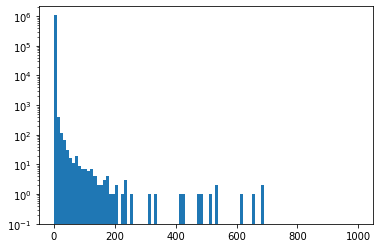

In [49]:
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=0.1)

(0.1, 2142985.069460987)

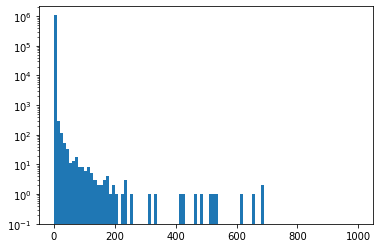

In [50]:
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=0.1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final', ylabel='Density'>

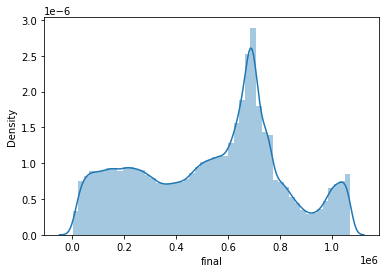

In [53]:
sns.distplot(scores['final'])

## Output the merged file

In [178]:
df = pd.read_csv("NY property data.csv")
df1=df[df.index.isin(top_records)]
df2=scores[scores.index.isin(top_records)]

In [179]:
out = df1.merge(df2[['score1 rank','score2 rank','final']], how='left', left_index=True, right_index=True)

In [194]:
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,-0.255761,1.391255,0.298531,-0.016532,0.733160,0.191155,-0.032729,1.279582,0.410407,-0.316187,...,0.239674,-0.291407,1.378940,0.423640,-0.035493,0.353823,0.146368,-0.069324,0.464675,0.328655
1,80.032072,14.476590,4.049227,22.085202,2.552784,0.699158,89.652154,11.941798,3.980206,45.870785,...,3.246255,49.308730,14.368584,4.673052,5.392397,1.275732,0.561827,22.564714,4.551318,3.292858
2,0.075242,-0.120576,-0.108520,0.483982,0.070334,0.028791,0.337016,0.047709,0.022988,-0.125772,...,-0.086621,-0.086920,-0.121835,-0.037535,0.087427,0.018003,0.013581,0.023990,-0.007480,0.006960
3,-0.182636,0.126486,0.113608,0.133577,0.303320,0.231186,0.048955,0.249021,0.234403,-0.274121,...,0.091438,-0.246232,0.123420,0.214128,0.001372,0.136044,0.179106,-0.048709,0.069679,0.182510
4,0.685581,22.822842,35.829707,1.602135,24.336380,37.030788,1.018790,18.742506,34.227910,0.225337,...,28.721692,0.290135,22.653802,40.679265,0.362030,12.312361,30.274899,0.196051,7.157913,28.409205


In [198]:
top_records[:10]

Int64Index([917941, 565391, 85885, 684703, 67128, 915468, 690832, 44247,
            1059882, 116646],
           dtype='int64')

In [208]:
dff=pd.read_csv('Original Top 100 Fraud Score-Zining Han.csv')
rec=dff['RECORD'][:10]
rec

0     917942
1     565392
2      85886
3      67129
4     684704
5     690833
6     915469
7      44248
8     565398
9    1059883
Name: RECORD, dtype: int64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5]),
 [Text(0.5, 1, 'r1'),
  Text(1.5, 1, 'r2'),
  Text(2.5, 1, 'r3'),
  Text(3.5, 1, 'r4'),
  Text(4.5, 1, 'r5'),
  Text(5.5, 1, 'r6'),
  Text(6.5, 1, 'r7'),
  Text(7.5, 1, 'r8'),
  Text(8.5, 1, 'r9'),
  Text(9.5, 1, 'r1_zip5'),
  Text(10.5, 1, 'r2_zip5'),
  Text(11.5, 1, 'r3_zip5'),
  Text(12.5, 1, 'r4_zip5'),
  Text(13.5, 1, 'r5_zip5'),
  Text(14.5, 1, 'r6_zip5'),
  Text(15.5, 1, 'r7_zip5'),
  Text(16.5, 1, 'r8_zip5'),
  Text(17.5, 1, 'r9_zip5'),
  Text(18.5, 1, 'r1_zip3'),
  Text(19.5, 1, 'r2_zip3'),
  Text(20.5, 1, 'r3_zip3'),
  Text(21.5, 1, 'r4_zip3'),
  Text(22.5, 1, 'r5_zip3'),
  Text(23.5, 1, 'r6_zip3'),
  Text(24.5, 1, 'r7_zip3'),
  Text(25.5, 1, 'r8_zip3'),
  Text(26.5, 1,

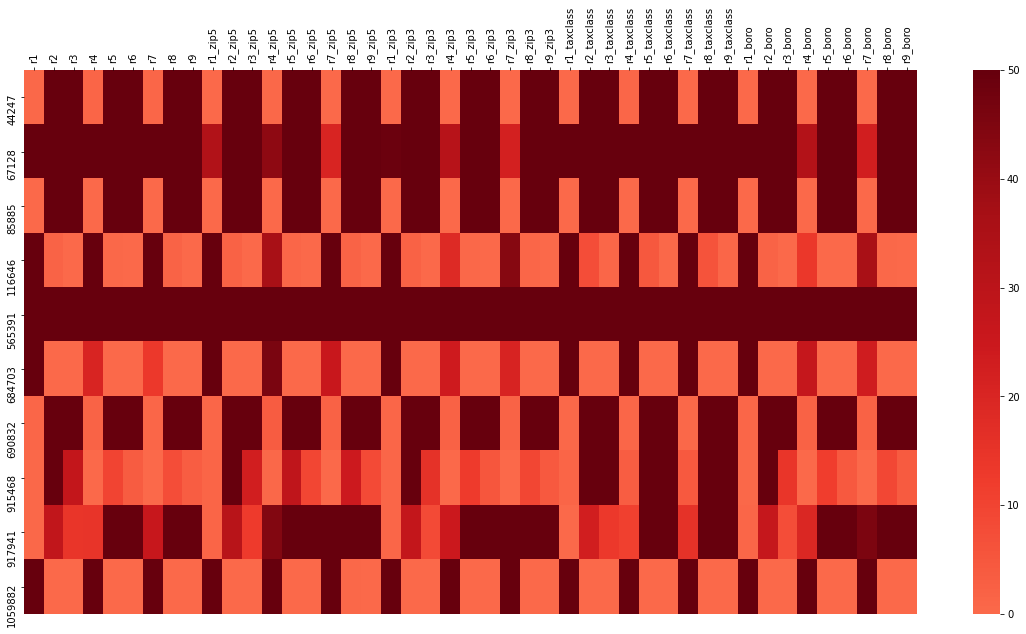

In [211]:
data_heatmap = data[data.index.isin(top_records[:10])].abs().head(10)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)

In [158]:
out.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
418,419,1000160003,1,16,3,NaN,THE CITY OF NEW YORK,Z9,4,2290,...,107827403.0,106883843.0,107827403.0,NaN,FINAL,2010/11,AC-TR,1070980.0,1070980.0,1070980.0
7053,7054,1000580001,1,58,1,NaN,THE PORT AUTHORITY OF,O4,4,950,...,289962000.0,219312000.0,289962000.0,NaN,FINAL,2010/11,AC-TR,1070905.0,1070904.0,1070904.5
12075,12076,1001790001,1,179,1,NaN,15 WORTH STREET PROPE,G6,4,74,...,941400.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070922.0,1070923.0,1070922.5
19241,19242,1004030001,1,403,1,NaN,PARKS AND RECREATION,Q1,4,687,...,15048000.0,13842000.0,15048000.0,NaN,FINAL,2010/11,AC-TR,1070968.0,1070968.0,1070968.0
26242,26243,1005490001,1,549,1,NaN,PARKS AND RECREATION,Q1,4,950,...,60606990.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070926.0,1070927.0,1070926.5


In [181]:
out=out.sort_values(['final'], ascending = False)
out.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
917941,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
684703,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
67128,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0


In [182]:
out.to_csv('New Top 100 Fraud Score-Zining Han.csv',index=False)

# Assignment 4

In [190]:
old=pd.read_csv('Original Top 100 Fraud Score-Zining Han.csv')
new=pd.read_csv('New Top 100 Fraud Score-Zining Han.csv')

In [191]:
top_old=old['RECORD']
top_new=new['RECORD']

In [193]:
res=list(set(list(top_old)).intersection(set(list(top_new))))
len(res)

95

In [ ]:
# p=2 p=2 PC=6
# p=3 p=4 PC=7